#  $\alpha$-Expansion Moves via Minimal Cuts for Segmentation

## Step 1 : load img

In [1]:
#Standart scientific python
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatch

#Network and image frameworks  
import networkx as nx
import cv2

Image of size  (212, 250)  with  3  channels.


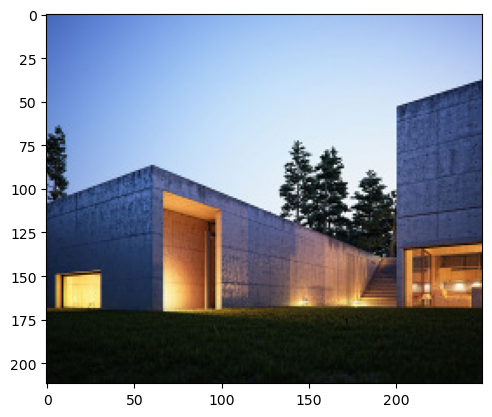

In [2]:
#Load an image
img = cv2.imread("Images/Haus-Koshino.jpg", cv2.IMREAD_COLOR)

#Image properties
w,h,d = img.shape
print('Image of size ', (w,h), ' with ', d, ' channels.')

#Display (Matplotlib uses RGB while OpenCV uses BGR)
plt.imshow(img[:,:,::-1]); 
plt.show()



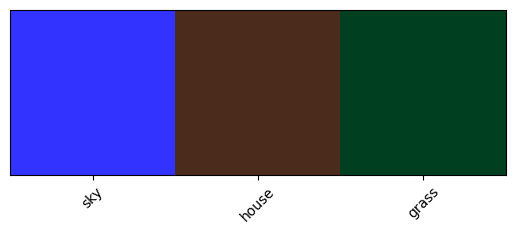

In [4]:
# create the color assignment

#step 1: chose label and colors 
labels = {
    'sky':   np.array([51,51,255]), 
    'house': np.array([ 74, 43, 28]),
    'grass': np.array([  0, 63, 31]),
} 
l = len( labels )

label_names  = [ k for k in labels.keys() ]
label_colors = np.array( [labels[k] for k in labels.keys()] )
labels = [s for s in range(0,l)] #Wlog
# plot the colors
plt.imshow(label_colors[np.newaxis,:,:]);
plt.yticks([]);
plt.xticks(np.arange(l), label_names, rotation=45)
plt.show()


# Step 2 : créer une fonction de courts qui indiquent combien coute le changement de cout 

In [5]:
def binary_cost(label_colors):
    cost=np.zeros((l,l))
    for i in range(l):
        for j in range(l):
            cost[i,j]=np.linalg.norm(label_colors[i]-label_colors[j])
    return cost
bin_cost=binary_cost(label_colors)
bin_cost.shape

(3, 3)

In [6]:
def unary_cost(img,label_colors):
    #correpond au cost phi(x_j)
    w,h,d=img.shape
    cost=np.zeros((w,h,l))
    for i in range(w):
        for j in range(h):
            for k in range(l):
                cost[i,j,k]=np.linalg.norm(img[i,j]-label_colors[k])
    return cost
un_cost=unary_cost(img,label_colors)
un_cost

array([[[235.86860749, 130.77461527, 191.50195821],
        [235.85800813, 132.3669143 , 192.85746032],
        [235.86012804, 133.96268137, 194.21894861],
        ...,
        [237.71621737, 227.2685636 , 272.38575587],
        [238.69645997, 228.05701042, 273.65854637],
        [238.69645997, 228.05701042, 273.65854637]],

       [[235.85800813, 132.3669143 , 192.85746032],
        [235.86012804, 133.96268137, 194.21894861],
        [235.87496688, 135.56179403, 195.58629809],
        ...,
        [238.47431728, 228.98908271, 274.00912394],
        [239.45563263, 229.77597786, 275.27804126],
        [239.45563263, 229.77597786, 275.27804126]],

       [[235.86012804, 133.96268137, 194.21894861],
        [235.87496688, 135.56179403, 195.58629809],
        [235.90252224, 137.16413525, 196.95938668],
        ...,
        [240.02083243, 232.43063481, 277.25980596],
        [239.24255474, 230.70977439, 275.63381505],
        [239.24255474, 230.70977439, 275.63381505]],

       ...,

      

In [7]:

def first_guess(img,unary_cost):
    return np.argmin(unary_cost,axis=-1)
assignement=first_guess(img,un_cost)
assignement

array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [2, 2, 2, ..., 2, 2, 2],
       [2, 2, 2, ..., 2, 2, 2],
       [2, 2, 2, ..., 2, 2, 2]], dtype=int64)

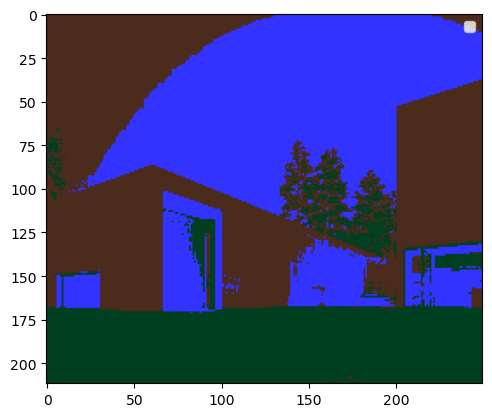

In [8]:
# plot the first assignement
plt.imshow(label_colors[assignement])
# add the legend with the colors
plt.legend(label_names)
plt.show()

# Step 2.5 convert to networkx

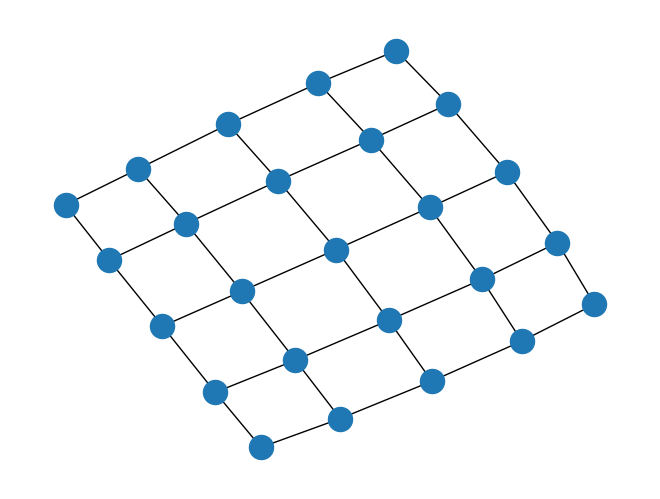

In [9]:
def create_graph(img,un_cost,bin_cost):
    w,h,d=img.shape
    G=nx.grid_2d_graph(w,h)
    # print it 
    return G
# draw the graph
nx.draw(create_graph(img[0:5,0:5,:],un_cost,bin_cost))
First_graph=create_graph(img,un_cost,bin_cost)

# STep 3 : Alpha expansion move

In [73]:
#Compute alpha-expansion optimization graph
def expansion_graph(G, assignement, alpha, un_cost, bin_cost):
    G_a = nx.Graph()
    
    #Add nodes
    G_a.add_nodes_from([e for e in G.nodes()])
    # Terminal node
    G_a.add_node( 'alpha' ) 
    # Non terminal node 
    G_a.add_node( 'nonalpha' )
    
    # for all edge e such that  fp!=fq, add a auxialiray node
    for e in G.edges():
        u,v = e 
        if assignement[u] != assignement[v]:
            G_a.add_node( e )
    
    #Link nodes to terminal nodes (  see talpha_p and t_alphab_p in base article)
    for v in G.nodes():
        G_a.add_edge( v,'alpha', weight=un_cost[v][alpha] )
        if assignement[v] == alpha:
            G_a.add_edge( v,'nonalpha', weight=float('inf') )
        else:
            G_a.add_edge( v,'nonalpha', weight=un_cost[v[0],v[1],assignement[v]] )
    
    # now link edge inside the graph :
    #Add edges with pairwise costs

    for e in G.edges():
        p,q = e
        if assignement[p]!=assignement[q]:
            G_a.add_edge(p,e,weight=bin_cost[assignement[p],alpha])
            G_a.add_edge(q,e,weight=bin_cost[assignement[q],alpha])
            G_a.add_edge(e,'nonalpha',weight=bin_cost[assignement[p],assignement[q]])
        
        
        else: # case assigmenet[p]==assignement[q]
            #todo!
            G_a.add_edge(p,q,weight=bin_cost[assignement[p],alpha])

        # # discard it !
        # if assignement[u] == assignement[v]:
        #     # print("e",e)
        #     # print(bin_cost[e].shape)
        #     # print(bin_cost[e][alpha, assignement[u]])
        #     G_a.add_edge( u,v, weight=bin_cost[alpha, assignement[u]] )
        # else:
        #     G_a.add_edge( u, e, weight=bin_cost[alpha, assignement[u]] )
        #     G_a.add_edge( v, e, weight=bin_cost[alpha, assignement[v]] )
        #     G_a.add_edge( e, 'nonalpha', weight=bin_cost[assignement[u],assignement[v]] )
    
    return G_a
small= cv2.resize(img, (0,0), fx=0.1, fy=0.1)
First_graph=create_graph(small,un_cost,bin_cost)
un_cost=unary_cost(small,label_colors) 

expansion_graph(First_graph,assignement,0,un_cost,bin_cost)
# draw it 
nx.draw(expansion_graph(First_graph,assignement,0,un_cost,bin_cost))

error: OpenCV(4.11.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\resize.cpp:4214: error: (-215:Assertion failed) !dsize.empty() in function 'cv::resize'


In [77]:
def alpha_expansion(G, assignement, alpha, un_cost, bin_cost):
    G_a = expansion_graph(G,assignement,alpha, un_cost, bin_cost)
    cutvalue, partition = nx.minimum_cut(G_a, 'alpha', 'nonalpha', capacity='weight')
    S,T = partition
    print("alpha in S?", 'alpha' in S)
    print("alpha in T?", 'alpha' in T)
    print("in T", T)
    for v in G.nodes():
        if v in T:
            assignement[v] = alpha
    return assignement

# whole algorihtm:

In [58]:
un_cost.shape

(2, 2, 3)

In [75]:
def compute_energy(G,assignement,un_cost,binary_cost):
    energy=0
    for node in G.nodes():
        energy+=un_cost[node[0],node[1],assignement[node]]
    for edge in G.edges():
        u,v=edge
        energy+=binary_cost[assignement[u],assignement[v]]
    return energy

In [ ]:
def whole_alpha_expansion(G,assignement,un_cost,bin_cost,ncycle:int=5):
    print("number of cycle",ncycle)
    num_label=un_cost.shape[-1]
    # number of different possible assignement.
    energy=compute_energy(G,assignement,un_cost,bin_cost)
    print("the initial energy",energy)
    for i in range(ncycle):
        print("start cycle i")
        # create a random permutation
        perm = np.random.permutation(l)
        perm
        print("the perm",perm)
        # run the alpha expansion
        for alpha in perm:
            print("we are doing the alpha expansion for the label",alpha)
            assignement=alpha_expansion(G,assignement,alpha,un_cost,bin_cost)
            new_energy=compute_energy(G,assignement,un_cost,bin_cost)
            print("new energy",new_energy)
            plot_assignement(assignement)

        new_energy=compute_energy(G,assignement,un_cost,bin_cost)
        print("the new energy",new_energy)
    return assignement


In [28]:
def plot_assignement(assignement,label_colors,label_names):
    # plot the first assignement
    plt.imshow(label_colors[assignement])
    # add the legend with the colors
    plt.legend(label_names)
    plt.show()

## Actual whole algorithm:

(8, 10, 3)

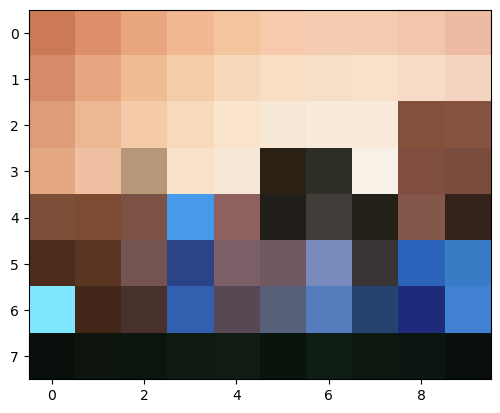

In [17]:
small = cv2.resize(img, (0,0), fx=0.2, fy=0.2) 
plt.imshow(small)
small.shape

In [70]:
img.shape

(2, 2, 3)

(2, 2, 3)


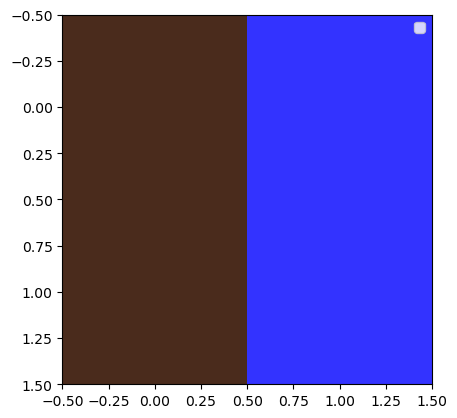

start assignement
number of cycle 1
the initial energy 1107.634564184252
start cycle i
the perm [2 1 0]
we are doing the alpha expansion for the label 2
alpha in S? True
alpha in T? False
in T {(0, 0), (0, 1), ((1, 0), (1, 1)), ((0, 0), (0, 1)), (1, 0), (1, 1), 'nonalpha'}
new energy 901.2356569791083
we are doing the alpha expansion for the label 1
alpha in S? True
alpha in T? False
in T {(0, 1), (0, 0), (1, 0), (1, 1), 'nonalpha'}
new energy 730.3521737425932
we are doing the alpha expansion for the label 0
alpha in S? True
alpha in T? False
in T {'nonalpha'}
new energy 730.3521737425932
the new energy 730.3521737425932


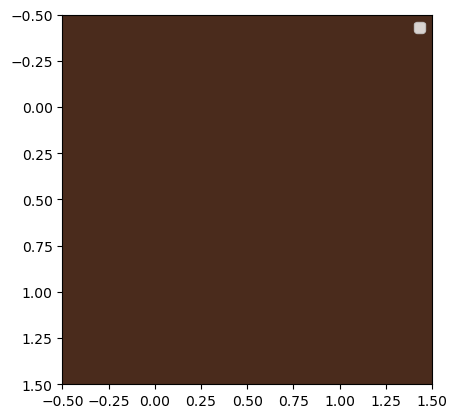

In [79]:
img = cv2.imread("Images/Haus-Koshino.jpg", cv2.IMREAD_COLOR)
img= cv2.resize(img, (0,0), fx=0.01, fy=0.01) 
print(img.shape)
labels = {
    'sky':   np.array([51,51,255]), 
    'house': np.array([ 74, 43, 28]),
    'grass': np.array([  0, 63, 31]),
} 
label_names  = [ k for k in labels.keys() ]
label_colors = np.array( [labels[k] for k in labels.keys()] )
labels = [s for s in range(0,l)] #Wlog
bin_cost=binary_cost(label_colors)
un_cost=unary_cost(img,label_colors)
First_graph=create_graph(img,un_cost,bin_cost)
assignement=first_guess(img,un_cost)
# plot the first assignement
plt.imshow(label_colors[assignement])
# add the legend with the colors
plt.legend(label_names)
plt.show()

print("start assignement")
assignement=whole_alpha_expansion(First_graph,assignement,un_cost,bin_cost,ncycle=1)

# plot the first assignement
plt.imshow(label_colors[assignement])
# add the legend with the colors
plt.legend(label_names)
plt.show()

In [53]:
un_cost.shape

(2, 2, 3)

In [30]:
np.unique(assignement,return_counts=True)

(array([1, 2], dtype=int64), array([425, 100], dtype=int64))

In [37]:
bin_cost

array([[  0.        , 228.302431  , 230.04564764],
       [228.302431  ,   0.        ,  76.71375366],
       [230.04564764,  76.71375366,   0.        ]])

In [62]:

alpha=0
assignement=alpha_expansion(First_graph,assignement,alpha,un_cost,bin_cost)


test (3,)
test (3,)
test (3,)
test (3,)
Cut value:  730.3521737425932
partition:  ({(0, 1), (0, 0), (1, 1), 'alpha', (1, 0)}, {'nonalpha'})
alpha in S? True
alpha in T? False
in T {'nonalpha'}


In [46]:
bin_cost[0,1]

228.30243099888358

In [49]:
# check if bin_cost is symmetric


array([[ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True]])

In [43]:
un_cost[:,:,]

(21, 25, 3)

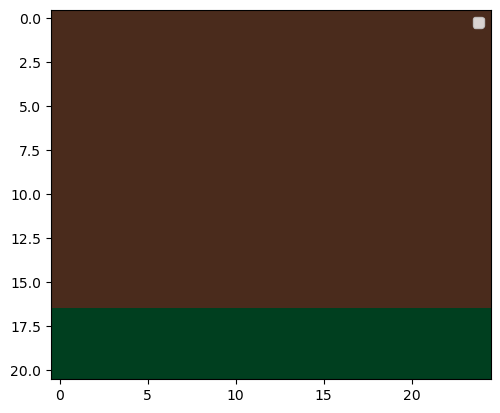

In [35]:
plot_assignement(assignement,label_colors,label_names)

[0, 1, 2]

(2, 2, 3)
(3, 2, 3)


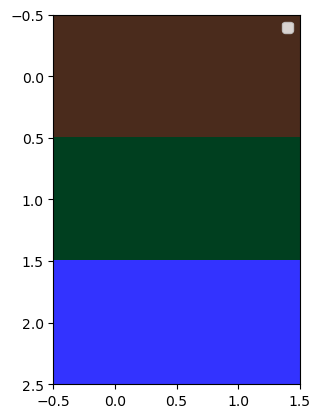

start assignement
number of cycle 5
the initial energy 1683.642467198395
start cycle i
the perm [0 1 2]
we are doing the alpha expansion for the label 0
alpha in S? True
alpha in T? False
in T {(0, 1), ((1, 1), (2, 1)), (2, 1), ((1, 0), (2, 0)), (0, 0), (1, 1), 'nonalpha', (2, 0), ((0, 1), (1, 1)), (1, 0), ((0, 0), (1, 0))}
new energy 916.6961572859958
we are doing the alpha expansion for the label 1
alpha in S? True
alpha in T? False
in T {(1, 0), (2, 1), (2, 0), (1, 1), 'nonalpha'}
new energy 610.0323693098525
we are doing the alpha expansion for the label 2
alpha in S? True
alpha in T? False
in T {'nonalpha'}
new energy 610.0323693098525
the new energy 610.0323693098525
start cycle i
the perm [0 1 2]
we are doing the alpha expansion for the label 0
alpha in S? True
alpha in T? False
in T {(0, 1), 'nonalpha', (0, 0)}
new energy 610.0323693098525
we are doing the alpha expansion for the label 1
alpha in S? True
alpha in T? False
in T {(2, 0), (2, 1), (1, 0), (1, 1), 'nonalpha'}
new en

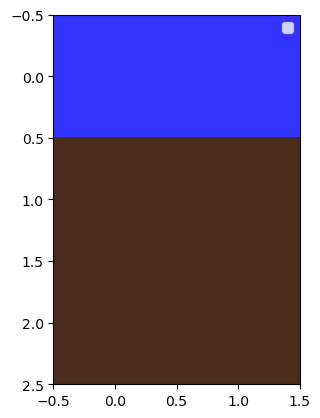

In [95]:
img = cv2.imread("Images/Haus-Koshino.jpg", cv2.IMREAD_COLOR)
img= cv2.resize(img, (0,0), fx=0.01, fy=0.01) 
print(img.shape)
labels = {
    'sky':   np.array([51,51,255]), 
    'house': np.array([ 74, 43, 28]),
    'grass': np.array([  0, 63, 31]),
} 
img=np.array([
    [
    labels['sky'],labels["sky"]],
    [labels['house'],labels["house"]],
    [labels['grass'],labels["grass"]]
])
print(img.shape)
label_names  = [ k for k in labels.keys() ]
label_colors = np.array( [labels[k] for k in labels.keys()] )
labels = [s for s in range(0,l)] #Wlog
bin_cost=binary_cost(label_colors)
un_cost=unary_cost(img,label_colors)
First_graph=create_graph(img,un_cost,bin_cost)
# assignement=first_guess(img,un_cost)
assignement=np.array([
    [1,1],
    [2,2],
    [0,0]
])
# plot the first assignement
plt.imshow(label_colors[assignement])
# add the legend with the colors
plt.legend(label_names)
plt.show()

print("start assignement")
assignement=whole_alpha_expansion(First_graph,assignement,un_cost,bin_cost,ncycle=5)

# plot the first assignement
plt.imshow(label_colors[assignement])
# add the legend with the colors
plt.legend(label_names)
plt.show()